In [1]:
# Import required packages
import sys
# !{sys.executable} -m pip install seaborn
from glob import glob
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from shutil import copy
from distutils.dir_util import copy_tree


In [2]:
# A helper dictionary and a save parameter
function_dict={'quad16qubit':'Quadratic','lin16qubit':'Linear','sin16qubit':'Sine'}
save=True

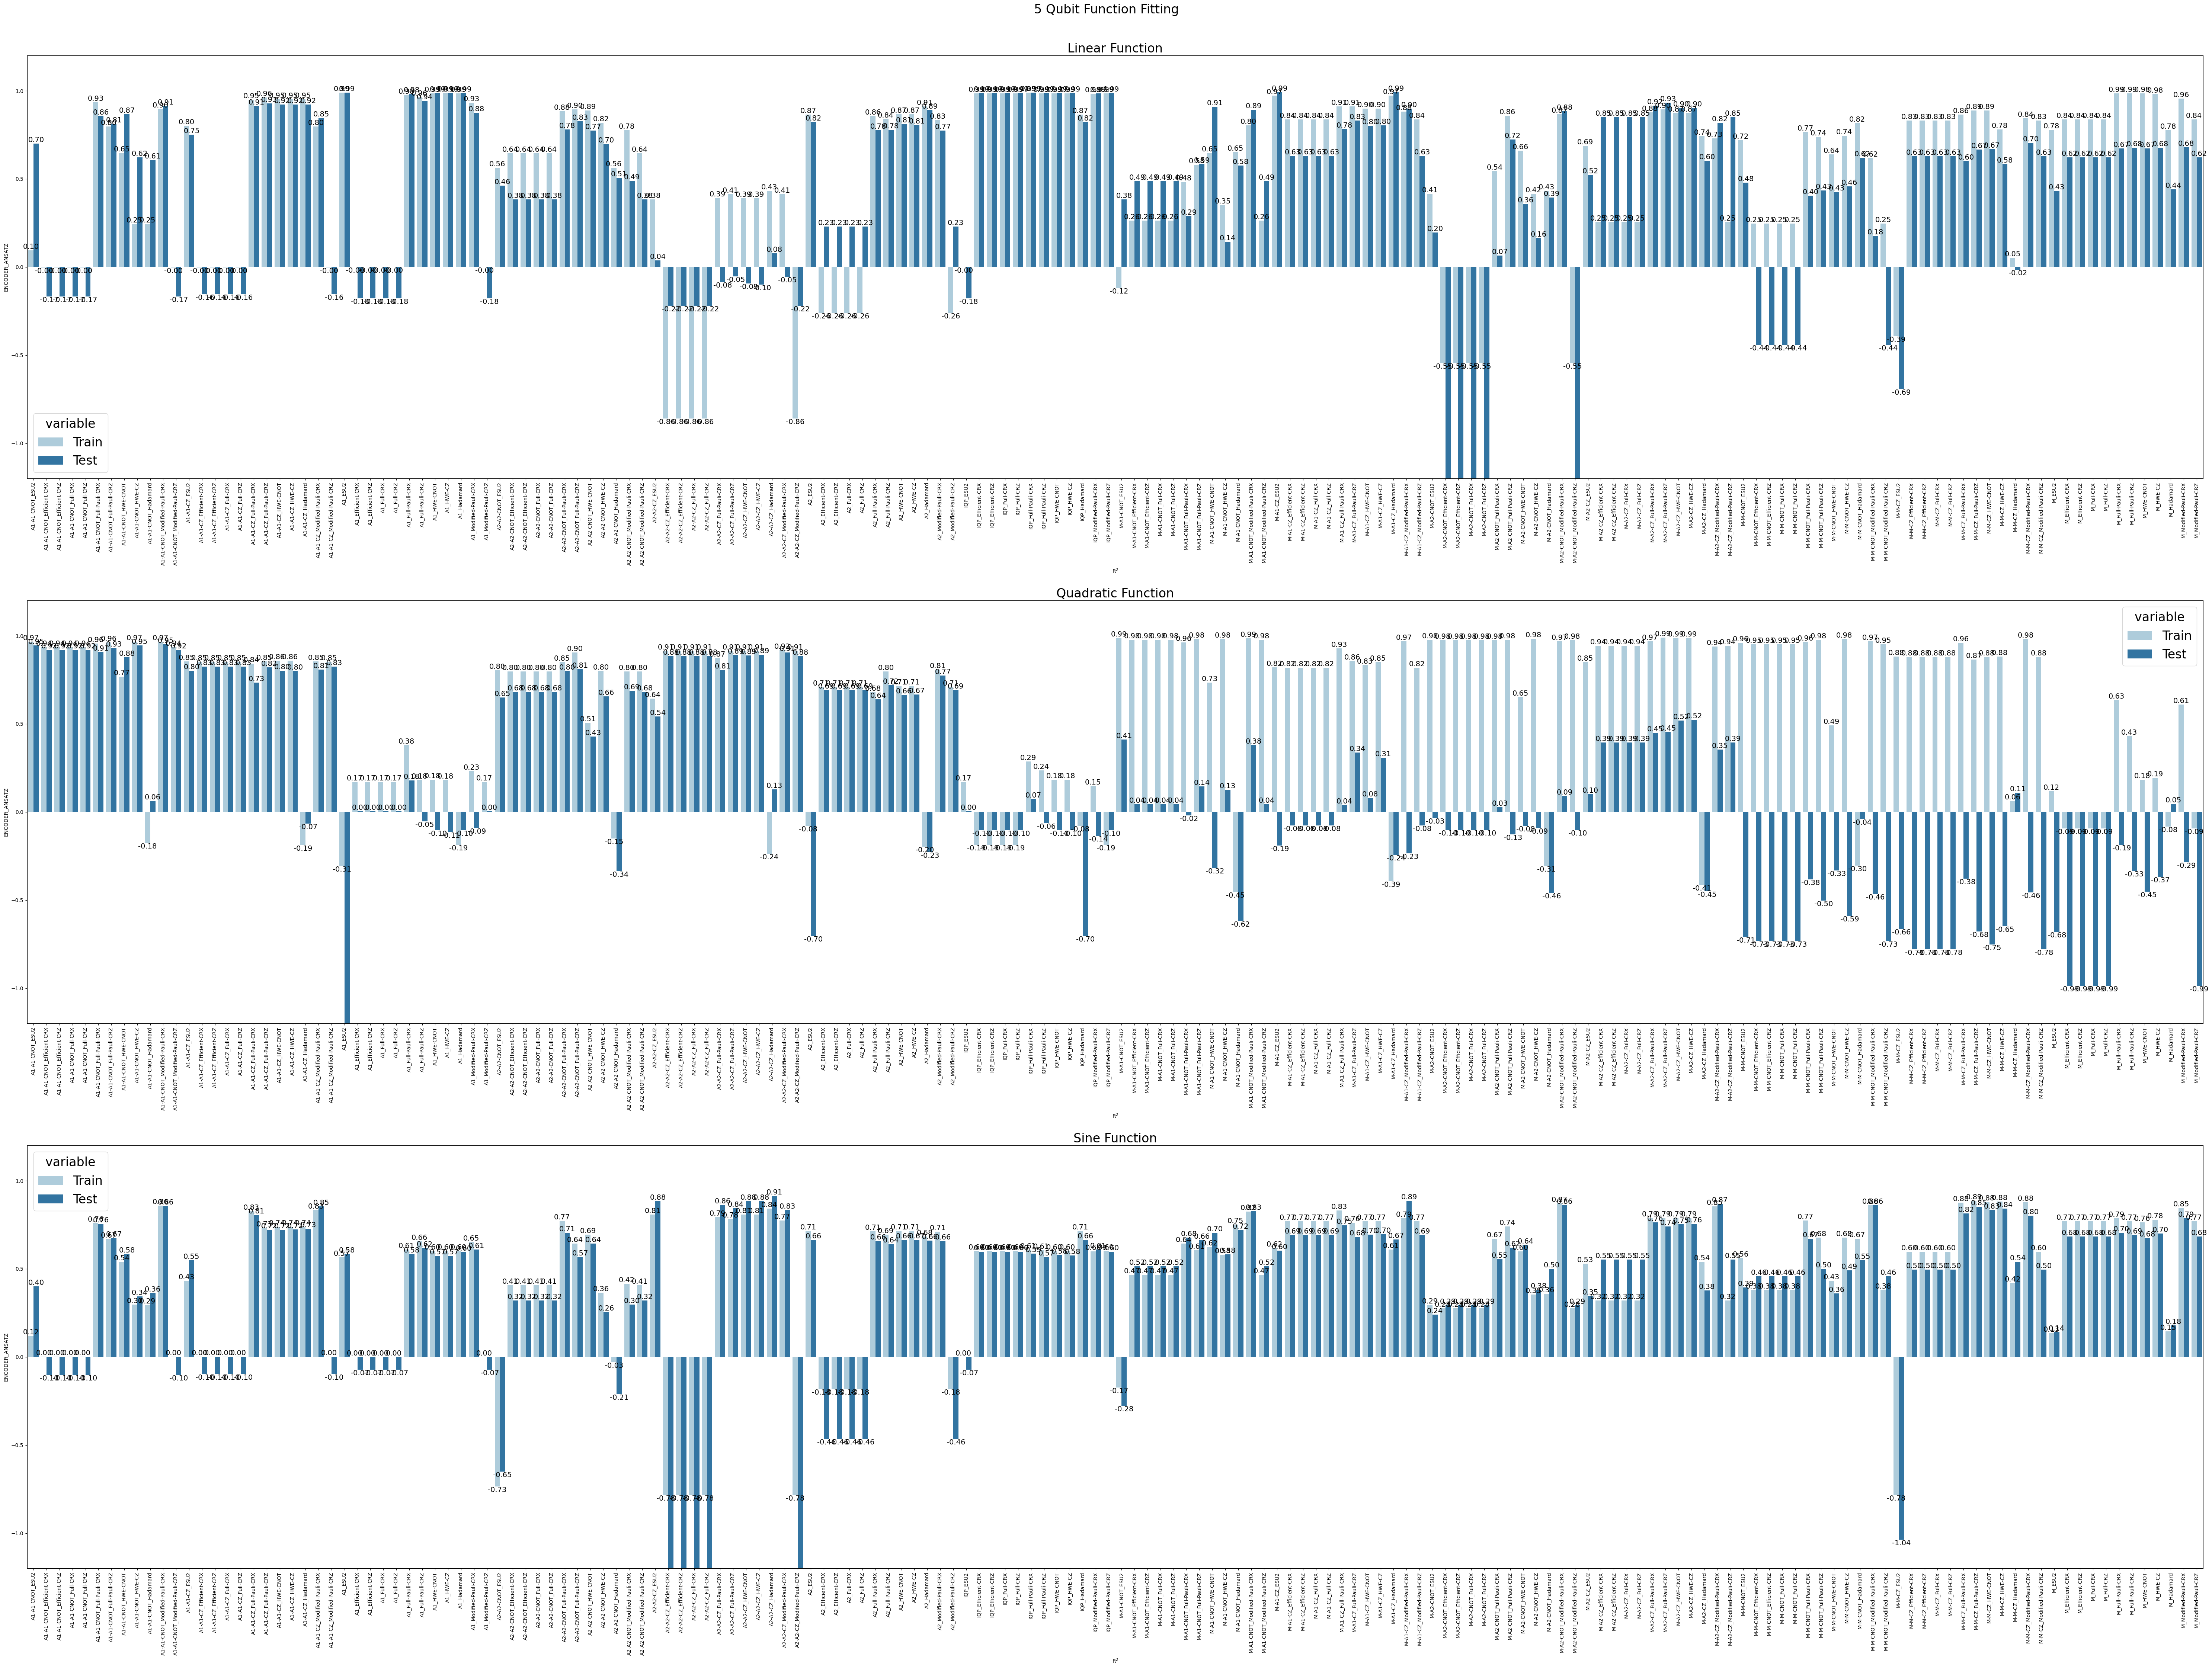

In [3]:
# Plot R^2
fig,ax = plt.subplots(3,1,figsize=(60,45),sharey=True)
SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
baseline={}
stacked_df=[]
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f"function-calc-test/fivequbit_tests/{k.replace('16','5')}/*/*results.json"):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    baseline[k.replace('16','5')]=results
    r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'})
    stacked=r2_df.copy()
    stacked['function']=len(stacked)*[v]
    stacked_df.append(stacked)
    
    sns.barplot(data=r2_df.reset_index().melt(id_vars='index'),y='value',x='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx])
    ax[idx].set_xlabel('R$^{2}$')
    ax[idx].set_ylabel('ENCODER_ANSATZ')
    ax[idx].set_title(f"{v} Function")
    ax[idx].tick_params(axis='x', labelrotation=90)
    ax[idx].set_ylim(-1.2,1.2)
    for c in ax[idx].containers:
        ax[idx].bar_label(c, fmt='{:.2f}',fontsize=14)    
fig.suptitle('5 Qubit Function Fitting',y=1)
plt.tight_layout()
if save:
    plt.savefig('5qubit_funcfit_R2.png',dpi=300,bbox_inches='tight')
plt.show()

In [4]:
stacked_df=pd.concat(stacked_df)

In [5]:
stacked_df.index=pd.MultiIndex.from_tuples(list(zip(stacked_df.index,stacked_df.function)))

In [6]:
stacked_df=stacked_df.drop(columns='function')

In [7]:
df=pd.DataFrame([stacked_df.loc[name].stack() for name in np.unique(np.array(list(stacked_df.index))[:,0])])
df.index=np.unique(np.array(list(stacked_df.index))[:,0])
# df=df.stack().stack().reset_index()
# df['level_4']=list(zip(df['level_1'],df['level_2']))
# df=df.drop(columns=['level_1','level_2'])

In [8]:
df.stack().stack().to_frame().reset_index()

,level_0,level_1,level_2,0
0,A1-A1-CNOT_ESU2,Train,Linear,0.095586
1,A1-A1-CNOT_ESU2,Train,Quadratic,0.966782
2,A1-A1-CNOT_ESU2,Train,Sine,0.119244
3,A1-A1-CNOT_ESU2,Test,Linear,0.700965
4,A1-A1-CNOT_ESU2,Test,Quadratic,0.946066
...,...,...,...,...
1003,M_Modified-Pauli-CRZ,Train,Quadratic,-0.094050
1004,M_Modified-Pauli-CRZ,Train,Sine,0.769609
1005,M_Modified-Pauli-CRZ,Test,Linear,0.622269
1006,M_Modified-Pauli-CRZ,Test,Quadratic,-0.986211


/Users/grierjones/miniconda3/lib/python3.12/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


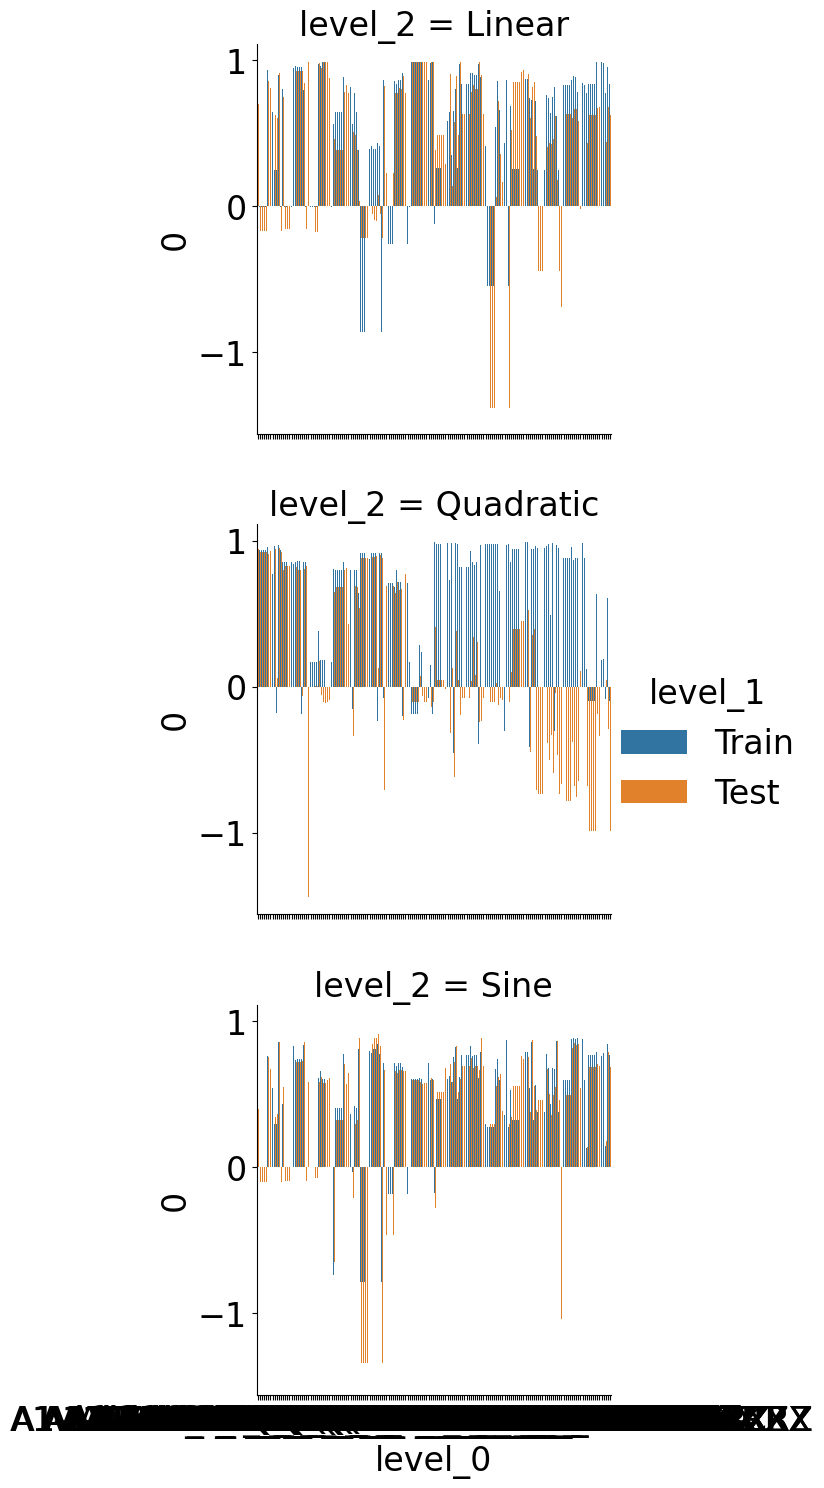

In [9]:
sns.catplot(data=df.stack().stack().to_frame().reset_index(),x='level_0',y=0,hue='level_1',row='level_2',kind='bar')

In [10]:
df.T.stack().to_frame().reset_index(level=2)

level_2         0
Linear Train           A1-A1-CNOT_ESU2  0.095586
       Train  A1-A1-CNOT_Efficient-CRX -0.002520
       Train  A1-A1-CNOT_Efficient-CRZ -0.002520
       Train       A1-A1-CNOT_Full-CRX -0.002520
       Train       A1-A1-CNOT_Full-CRZ -0.002520
...                                ...       ...
Sine   Test                 M_HWE-CNOT  0.675127
       Test                   M_HWE-CZ  0.701004
       Test                 M_Hadamard  0.179227
       Test       M_Modified-Pauli-CRX  0.787500
       Test       M_Modified-Pauli-CRZ  0.683022

[1008 rows x 2 columns]

In [11]:
df[['level_1','level_2']].apply(tuple, axis=1)

KeyError: "['level_1' 'level_2'] not in index"

In [ ]:
sns.barplot(data=df,y='level_0',x=0,hue=df[['level_1','level_2']].apply(tuple, axis=1))

In [12]:
id_vars=['A'], value_vars=['B']

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (1244892239.py, line 1)

In [ ]:
melt_stack=stacked_df.melt(value_vars=['Train','Test'],ignore_index=False).reset_index()

In [ ]:
stacked_df.stack(level=0).to_frame()

In [ ]:
np.unique(np.array(list(stacked_df.index))[:,0]),np.unique(np.array(list(stacked_df.index))[:,1])

In [ ]:
list(stacked_df.index)

In [ ]:
g = sns.catplot(data=melt_stack, kind='bar', x='level_0', y='value', hue='level_1', palette='viridis')


In [ ]:
sns.barplot(data=melt_stack,x='level_0',y='value',hue=melt_stack[['level_1','variable']])

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(15,45))
ax=sns.barplot(data=pd.concat(stacked_df).reset_index(),y='index',x='Train',hue='function')

In [ ]:
# Plot R^2
fig,ax = plt.subplots(1,3,figsize=(30,15),sharey=True)
SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
baseline={}
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    baseline[k]=results
    r2_df=pd.DataFrame.from_dict(results).T[['R2_train','R2_test']].sort_index().rename(columns={'R2_train':"Train",'R2_test':'Test'})
    sns.barplot(data=r2_df.reset_index().melt(id_vars='index'),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx])
    ax[idx].set_xlabel('R$^{2}$')
    ax[idx].set_ylabel('ENCODER_ANSATZ')
    ax[idx].set_title(f"{v} Function")
    ax[idx].tick_params(axis='x', labelrotation=90)
    ax[idx].set_xlim(-1.2,1.2)
    for c in ax[idx].containers:
        ax[idx].bar_label(c, fmt='{:.2f}',fontsize=14)    
fig.suptitle('16 Qubit Function Fitting')
plt.tight_layout()
if save:
    plt.savefig('16qubit_funcfit_R2.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
# Plot MAE (kcal/mol)
fig,ax = plt.subplots(1,3,figsize=(30,15),sharey=True)
SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    MAE_df=pd.DataFrame.from_dict(results).T[['MAE_train','MAE_test']].sort_index().rename(columns={'MAE_train':"Train",'MAE_test':'Test'})
    
    sns.barplot(data=MAE_df.reset_index().melt(id_vars='index'),x='value',y='index',hue='variable',palette=sns.color_palette("Paired",2),ax=ax[idx])
    ax[idx].set_xlabel('Mean Absolute Error (unitless)')
    ax[idx].set_ylabel('ENCODER_ANSATZ')
    ax[idx].set_title(f"{v} Function")
    ax[idx].tick_params(axis='x', labelrotation=90)
    ax[idx].set_xlim(0,np.ceil(MAE_df.max().max()).astype(int)+1)
    for c in ax[idx].containers:
        ax[idx].bar_label(c, fmt='{:.2f}',fontsize=14)    
    ax[idx].legend(loc=1)
fig.suptitle('16 Qubit Function Fitting')
plt.tight_layout()

if save:
    plt.savefig('16qubit_funcfit_MAE.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:

results={}
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results[k]={}
    depth=[3,5]
    layers=['RUD','AL']
    for d in depth:
        results[k][d]={}
        for l in layers:
            results[k][d][l]={}
            for i in glob(f'function-calc-test/move2narval/{d}_{l}_{k}/*/*results.json'):
                dirname=os.path.basename(os.path.dirname(i))
                with open(i,'r') as f:
                    results[k][d][l][dirname]=json.load(f)
        # # print(dirname)
        # with open(i,'r') as f:
        #     results[dirname]={"baseline":baseline[k][dirname],"new":json.load(f)}

In [ ]:
help(ax.bar_label)

In [ ]:
# Plot MAE (kcal/mol)
# fig,ax = plt.subplots(1,3,figsize=(40,15),sharey=False)

SMALL_SIZE = 8
MEDIUM_SIZE = 24
BIGGER_SIZE = 12

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title
compiled_data={}
for idx,(k,v) in enumerate(results.items()):
    plt.figure(figsize=(20,40))
    stackedf=[]
    for kd,vd in v.items():
        for kl, vl in vd.items():
            
            df=pd.DataFrame.from_dict(vl).loc[['R2_train','R2_test']].T.rename(columns={'R2_train':'Train','R2_test':'Test'}).sort_index().reset_index().melt(id_vars='index', value_vars=['Train','Test'])
            df['variable']=['_'.join(t) for t in tuple(zip(df['variable'],len(df)*[str(kd)],len(df)*[kl]))]
            stackedf.append(df)

    stackeddf=pd.concat(stackedf)
    
    basedf=pd.DataFrame.from_dict(baseline[k]).loc[['R2_train','R2_test']].T.rename(columns={'R2_train':'Train','R2_test':'Test'}).loc[list(set(stackeddf['index']))].sort_index().reset_index().melt(id_vars='index', value_vars=['Train','Test'])
    basedf['variable']=['_'.join(t) for t in tuple(zip(basedf['variable'],len(basedf)*["baseline"]))]
    alldf=pd.concat([stackeddf,basedf])
    ax=sns.barplot(data=alldf,y='index',x='value',hue='variable',palette=sns.color_palette('Paired'),width=0.95)
    # Fix legend labels
    for text in plt.legend().get_texts():
        text.set_text(' '.join([i for i in text.get_text().split('_')]))
    # Add R2 to containers
    for container in ax.containers:
        ax.bar_label(container, fmt='{:.2f}',fontsize=MEDIUM_SIZE*0.75)

    plt.ylabel('ENCODER_ANSATZ')
    plt.xlabel("R$^{2}$")
    plt.xlim(-1.1,1.1)
    plt.title(f"{function_dict[k]} Re-upload and Ansatz Layers")
    
    if save:
        plt.savefig(f'{function_dict[k]}_16qubit_funcfit_R2_depth_layer.png',dpi=300,bbox_inches='tight')
    plt.show()
    compiled_data[k]=alldf

In [ ]:
# SPlit names into encoder and ansatz
enc_anz=np.array([i.split('_') for i in MAE_df.index])
if save:
    with open('16qubit_enc_anz.txt','w') as f:
        f.write('Encoders\n')
        f.write(''.join(len('Encoders')*['-'])+'\n')
        for i in np.unique(enc_anz[:,0]):
            f.write(i+'\n')
        f.write('\nAnsatz\n')
        f.write(''.join(len('Ansatz')*['-'])+'\n')
        for j in np.unique(enc_anz[:,1]):
            f.write(j+'\n')

In [ ]:
# Create dictionary of results for linear, quadratic, and sine function
func_results={}
for idx,(k,v) in enumerate(sorted(function_dict.items())):
    results={}
    for i in glob(f'function-calc-test/sixteenqubit_test/{k}/*/*results.json'):
        dirname=os.path.basename(os.path.dirname(i))
        with open(i,'r') as f:
            results[dirname]=json.load(f)
    func_results[v]=results

In [ ]:
# Find the best, worst, and middle 5 for linear function fitting
lindf=pd.DataFrame.from_dict(func_results['Linear']).T[['R2_train','R2_test']]

bottom_lin=lindf.T.mean().sort_values(ascending=False).iloc[-5:]
top_lin=lindf.T.mean().sort_values(ascending=False).iloc[:5]
linmed=len(lindf)//2
middle_lin=pd.concat([lindf.T.mean().astype(float).sort_values().iloc[linmed-2:linmed],lindf.T.mean().astype(float).sort_values().iloc[linmed:linmed+3]],axis=0)

mv_lin=list(bottom_lin.index)+list(top_lin.index)+list(middle_lin.index)

In [ ]:
# Find the best, worst, and middle 5 for quadratic function fitting
quaddf=pd.DataFrame.from_dict(func_results['Quadratic']).T[['R2_train','R2_test']]
bestfivequad=quaddf[quaddf>0].dropna().sort_values(by=['R2_test'],ascending=False).iloc[0:5]

bottom_quad=quaddf.T.mean().sort_values(ascending=False).iloc[-5:]
top_quad=quaddf.T.mean().sort_values(ascending=False).iloc[:5]
quadmed=len(quaddf)//2
middle_quad=pd.concat([quaddf.T.mean().astype(float).sort_values().iloc[quadmed-2:quadmed],quaddf.T.mean().astype(float).sort_values().iloc[quadmed:quadmed+3]],axis=0)

mv_quad=list(bottom_quad.index)+list(top_quad.index)+list(middle_quad.index)

In [ ]:
# Find the best, worst, and middle 5 for sine function fitting
sinedf=pd.DataFrame.from_dict(func_results['Sine']).T[['R2_train','R2_test']]
bestfivesine=sinedf[sinedf>0].dropna().sort_values(by=['R2_test'],ascending=False).iloc[0:5]

bottom_sine=sinedf.T.mean().sort_values(ascending=False).iloc[-5:]
top_sine=sinedf.T.mean().sort_values(ascending=False).iloc[:5]
sinemed=len(sinedf)//2
middle_sine=pd.concat([sinedf.T.mean().astype(float).sort_values().iloc[sinemed-2:sinemed],sinedf.T.mean().astype(float).sort_values().iloc[sinemed:sinemed+3]],axis=0)

mv_sine=list(bottom_sine.index)+list(top_sine.index)+list(middle_sine.index)

In [ ]:
# params:
# -RUD: re-upload depth
# -AL: ansatz layer depth
#
# param_depth: either 3 or 5 layers
params=['RUD','AL']
param_depth=[3,5]

In [ ]:
mv_dict={'quad16qubit':mv_quad,'sin16qubit':mv_sine,'lin16qubit':mv_lin}

In [ ]:
def write_run(top_dir,work_dir,func,writefile):
    """
    Write run.sh to file

    params
    ------
    top_dir: str
        Name of top directory in scratch
    
    work_dir: str
        Name of test directory
        
    func: str
        Function being tested

    writefile: str
        Path and file name in directory

    """
    runfile="""#! /bin/bash
for i in */; do
    name=${i%/}
    # Extracting the parent directory name
    settings_folder=${name#M-A1-CNOT_Efficient-CRX_}"""+f"""
    path="/home/gjones/scratch/{top_dir}/{work_dir}"""+"""/${name}"
    if [ ! -f ${path}/${name}_results.json ]; then
        echo "${name}.done not found!"
    	cat > ${name}.sub <<EOF
#! /bin/bash
#SBATCH -t 0-12:00:00
#SBATCH -J """+f"""{work_dir}"""+"""_${name}
#SBATCH -N 1
#SBATCH -n 12
#SBATCH --account=rrg-jacobsen-ab
#SBATCH --error=${name}.e%J        # The file where run time errors will be dumped
#SBATCH --output=${name}.o%J               # The file where the output of the terminal will be dumped

module load apptainer 
cd $(pwd)/$name"""+f"""

apptainer run -C -B /home/gjones/scratch/{top_dir}/{work_dir} ~/deb.sif /opt/miniconda/bin/python /home/gjones/scratch/{top_dir}/{work_dir}/main.py"""+"""--save_path ${path}  --settings ${path}/${name}.json"""+f""" --train_set /home/gjones/scratch/{top_dir}/{work_dir}/{func}_train.bin --test_set /home/gjones/scratch/{top_dir}/{work_dir}/{func}_test.bin --scaler /home/gjones/scratch/{top_dir}/{work_dir}/{func}_scaler.bin"""+""" >> ${name}.out 2>&1 

cd ..
touch ${name}.done

EOF
    fi
    echo "Done ${name}.sub"
done
"""
    with open(writefile,'w') as f:
        f.write(runfile)

In [ ]:
move=False
if move:
    # Move directories to new directory
    for idx,(k,v) in enumerate(sorted(function_dict.items())):
        for p in params:
            for pd in param_depth:
                dirname=f"{pd}_{p}_{k}"
                mv2narval=os.path.join(f'{os.getcwd()}/function-calc-test/move2narval/',dirname)
                if os.path.exists(mv2narval)==False:
                    os.mkdir(mv2narval)
                for subdir in mv_dict[k]:
                    copy_tree(f"{os.getcwd()}/function-calc-test/sixteenqubit_test/{k}/{subdir}",os.path.join(mv2narval,subdir))
                    # Write json files
                    jsonname=os.path.join(mv2narval,subdir,subdir+'.json')
                    with open(jsonname,'r') as f:
                        jsondict=json.load(f)
                    if p=='RUD':
                        jsondict['RE-UPLOAD_DEPTH']=pd
                    else:
                        jsondict['LAYERS']=pd
                    with open(jsonname,'w') as f:
                        json.dump(jsondict,f)
                        
    # Move data and helper files
    for k,v in function_dict.items():
        for subdir in glob(f'{os.getcwd()}/function-calc-test/move2narval/*_{k}'):
            # Move run.sh
            copy(f"{os.getcwd()}/function-calc-test/sixteenqubit_test/{k}/run.sh",subdir)
            for file in glob(f'{os.getcwd()}/function-calc-test/{v.lower()}/{v.lower()}*bin'):
                # Move data bin files
                copy(file,subdir)
            # Move helper files
            copy(f'{os.getcwd()}/function-calc-test/sixteenqubit_test/helperfiles.zip',subdir)
    # write run.sh
    for k,v in function_dict.items():
        print(v.lower())
        for filename in glob(f"./function-calc-test/move2narval/*{k}"):
            write_run("move2narval",os.path.basename(filename),v.lower(),os.path.join(filename,'run.sh'))
            # Copy resubmit.sh 
            copy("/home/grierjones/qregress/function-calc-test/sixteenqubit_test/lin16qubit/resubmit.sh",filename)
